In [11]:
import pandas as pd
from print_nanny_webapp.client_events.models import PredictEvent
from django.utils import timezone
from asgiref.sync import sync_to_async
import os

import matplotlib


In [12]:
CONFIDENCE_THRESHOLD = 0.50

LABELS = {
    1: 'nozzle',
    2: 'adhesion',
    3: 'spaghetti',
    4: 'print',
    5: 'raft',
}

FAILURES = {
    2: 'adhesion',
    3: 'spaghetti',  
}


In [13]:
import json
def dict_to_series(data):
    return pd.Series(data.values(), index=data.keys())

In [14]:
predict_events = PredictEvent.objects.all().order_by('-dt').values('id','predict_data')

df = pd.DataFrame.from_records(predict_events, index='id')
df = df['predict_data'].apply(dict_to_series)

NUM_DETECTIONS = len(df['detection_scores'].iloc[0])
print(NUM_DETECTIONS)

40


In [15]:
df = df.dropna()
df = df[['detection_classes', 'detection_scores']]
df = df.reset_index()
df = df.rename(columns={'id': 'frame_id' })

NUM_FRAMES = len(df)
df

,frame_id,detection_classes,detection_scores
0,804,"[5, 4, 3, 4, 3, 4, 3, 5, 4, 4, 2, 3, 4, 4, 3, ...","[0.7890625, 0.66015625, 0.5, 0.33984375, 0.269..."
1,803,"[5, 4, 3, 2, 4, 3, 4, 3, 4, 5, 2, 3, 3, 2, 2, ...","[0.7890625, 0.66015625, 0.58203125, 0.33984375..."
2,802,"[3, 5, 4, 2, 3, 4, 4, 4, 4, 4, 2, 5, 2, 4, 4, ...","[0.83984375, 0.73046875, 0.73046875, 0.2695312..."
3,801,"[3, 3, 1, 5, 1, 1, 4, 3, 4, 5, 4, 1, 3, 3, 4, ...","[0.01953125, 0.01953125, 0.01953125, 0.0117187..."
4,800,"[4, 4, 1, 3, 4, 1, 4, 3, 4, 4, 3, 4, 4, 4, 3, ...","[0.06640625, 0.06640625, 0.03515625, 0.0351562..."
...,...,...,...
735,5,"[4, 1, 3, 1, 5, 3, 1, 3, 4, 3, 2, 4, 4, 3, 1, ...","[0.08984375, 0.05078125, 0.03515625, 0.0351562..."
736,4,"[4, 1, 3, 3, 1, 1, 3, 4, 1, 4, 5, 5, 3, 4, 3, ...","[0.16015625, 0.06640625, 0.06640625, 0.0507812..."
737,3,"[1, 4, 5, 1, 3, 1, 5, 5, 5, 5, 3, 3, 4, 3, 4, ...","[0.08984375, 0.08984375, 0.05078125, 0.0507812..."
738,2,"[4, 1, 5, 1, 3, 3, 4, 1, 3, 3, 1, 3, 3, 3, 3, ...","[0.16015625, 0.06640625, 0.05078125, 0.0507812..."


In [16]:
print('Explode detection_classes and detection_scores together')
df = df.set_index(['frame_id']).apply(pd.Series.explode).reset_index()

assert len(df) == NUM_FRAMES * NUM_DETECTIONS
df

Explode detection_classes and detection_scores together


,frame_id,detection_classes,detection_scores
0,804,5,0.789062
1,804,4,0.660156
2,804,3,0.5
3,804,4,0.339844
4,804,3,0.269531
...,...,...,...
29595,1,3,0.0117188
29596,1,1,0.0117188
29597,1,3,0.0117188
29598,1,3,0.0117188


In [17]:
print('Add labels')
df['label'] = df['detection_classes'].map(LABELS)
df


Add labels


,frame_id,detection_classes,detection_scores,label
0,804,5,0.789062,raft
1,804,4,0.660156,print
2,804,3,0.5,spaghetti
3,804,4,0.339844,print
4,804,3,0.269531,spaghetti
...,...,...,...,...
29595,1,3,0.0117188,spaghetti
29596,1,1,0.0117188,nozzle
29597,1,3,0.0117188,spaghetti
29598,1,3,0.0117188,spaghetti


In [18]:
print('Create a hierarchal index')
df = df.set_index(['frame_id', 'label'])
df

Create a hierarchal index


detection_classes detection_scores
frame_id label                                       
804      raft                      5         0.789062
         print                     4         0.660156
         spaghetti                 3              0.5
         print                     4         0.339844
         spaghetti                 3         0.269531
...                              ...              ...
1        spaghetti                 3        0.0117188
         nozzle                    1        0.0117188
         spaghetti                 3        0.0117188
         spaghetti                 3        0.0117188
         raft                      5        0.0117188

[29600 rows x 2 columns]

Distribution of confidences


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'nozzle'}>],
       [<AxesSubplot:title={'center':'print'}>,
        <AxesSubplot:title={'center':'raft'}>],
       [<AxesSubplot:title={'center':'spaghetti'}>, <AxesSubplot:>]],
      dtype=object)

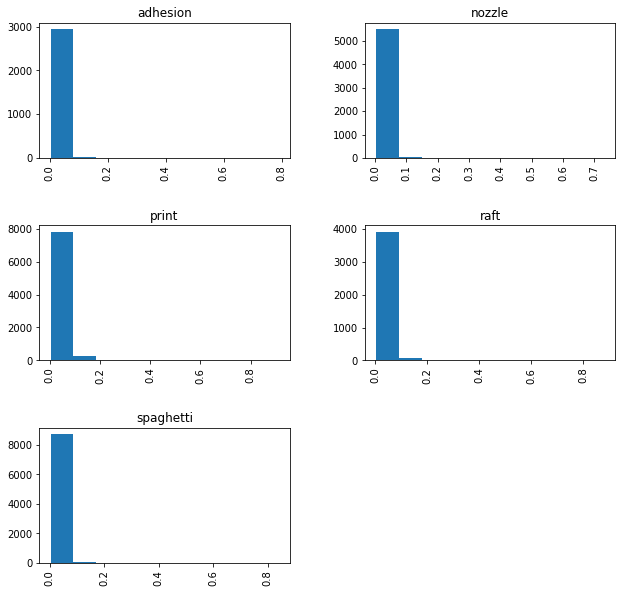

In [19]:
print(f'Distribution of confidences')
df['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidences > 0.5


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'nozzle'}>],
       [<AxesSubplot:title={'center':'print'}>,
        <AxesSubplot:title={'center':'raft'}>],
       [<AxesSubplot:title={'center':'spaghetti'}>, <AxesSubplot:>]],
      dtype=object)

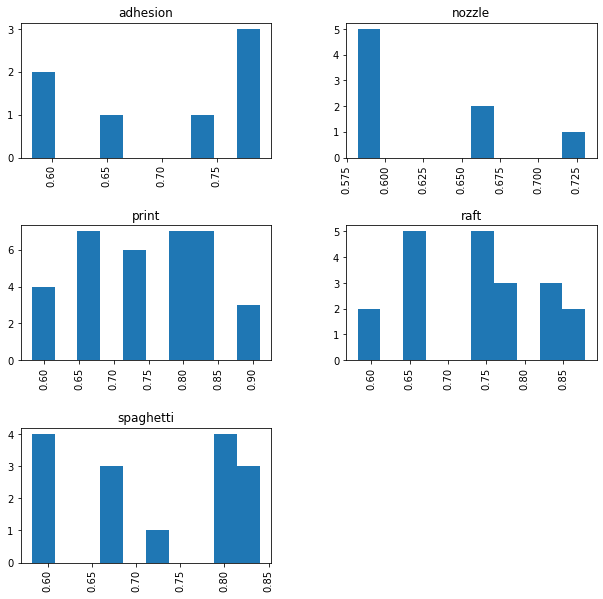

In [20]:
print(f'Distribution of confidences > {CONFIDENCE_THRESHOLD}')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidence scores > THRESHOLD, FAILURE vs. OK


array([<AxesSubplot:title={'center':'FAILURE'}>,
       <AxesSubplot:title={'center':'NEUTRAL'}>], dtype=object)

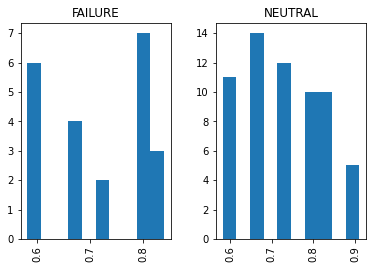

In [21]:
print('Distribution of confidence scores > THRESHOLD, FAILURE vs. OK')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by=lambda x: 'FAILURE' if x[1] in FAILURES.values() else 'NEUTRAL' )


In [22]:
print('Frames where at least 1 type of failure is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (df['detection_classes'].isin(FAILURES))

fail_df = df[mask]

fail_df

Frames where at least 1 type of failure is confidently detected


,,detection_classes,detection_scores
frame_id,label,,
803,spaghetti,3,0.582031
802,spaghetti,3,0.839844
785,spaghetti,3,0.660156
784,spaghetti,3,0.839844
783,spaghetti,3,0.789062
782,spaghetti,3,0.789062
781,adhesion,2,0.789062
780,adhesion,2,0.730469
779,adhesion,2,0.789062


In [23]:
print('Percent of frames where at least 1 type of failure is confidently detected')
(len(fail_df) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of failure is confidently detected


2.9729729729729732

In [24]:
print('Frames where at least 1 type of neutral is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (~df['detection_classes'].isin(FAILURES))

neutral_df = df[mask]

neutral_df 

Frames where at least 1 type of neutral is confidently detected


detection_classes detection_scores
frame_id label                                    
804      raft                   5         0.789062
         print                  4         0.660156
803      raft                   5         0.789062
         print                  4         0.660156
802      raft                   5         0.730469
...                           ...              ...
740      nozzle                 1         0.582031
739      print                  4         0.730469
         raft                   5         0.582031
738      print                  4         0.660156
688      print                  4         0.839844

[62 rows x 2 columns]

In [25]:
print('Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected')
(len(neutral_df ) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected


8.378378378378379

In [28]:
print('Ratio of frames with at least 1 failure detected : frames with at least 1 neutral detected')

len(fail_df) / (len(neutral_df ))

Ratio of frames with at least 1 failure detected : frames with at least 1 neutral detected


0.3548387096774194

In [35]:
tuple(df[df['detection_scores'] > CONFIDENCE_THRESHOLD].groupby(level='label').size().items())

(('adhesion', 7),
 ('nozzle', 8),
 ('print', 34),
 ('raft', 20),
 ('spaghetti', 15))

In [94]:
fail_df.groupby('frame_id').size()
neutral_df.groupby('frame_id').size()

#confident_df = df[df['detection_scores'] > CONFIDENCE_THRESHOLD]
tuple(confident_df.groupby(['frame_id', 'label']).size().items())



#/ len(neutral_df.groupby('frame_id'))

1.9e-06